In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

seed = 7
#set_seed(seed)

# User input: choose mesh

In [2]:
mesh=40

Load data

In [3]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

       CV_f_v  ani_ratio_v    k_FEC    CV_f_a  ani_ratio_a     k_BB
0    0.606444     0.442714  5.53288  0.317814     0.376440  1.35358
1    0.518476     0.304389  6.83032  0.628421     0.237364  1.25791
2    0.641101     0.239081  5.82181  1.020680     0.437033  5.30559
3    0.750099     0.373713  4.49537  0.526532     0.444927  2.07317
4    0.689263     0.388615  2.34609  0.556797     0.477035  2.36587
..        ...          ...      ...       ...          ...      ...
115  0.545148     0.260282  1.41140  0.982380     0.242211  2.02864
116  0.407284     0.272427  1.55631  0.353259     0.340049  1.65963
117  0.796166     0.465371  7.16628  0.539272     0.228129  1.68568
118  0.752534     0.476168  3.40841  0.386740     0.264407  5.40274
119  0.687991     0.318799  6.32706  0.767307     0.234231  4.38626

[120 rows x 6 columns]


In [4]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

        A_TAT     V_TAT
0    326.3430  100.5180
1    183.9530  130.7160
2     78.6365  115.3240
3    174.7200   86.9669
4    159.2430   95.3313
..        ...       ...
115  107.5570  140.7120
116  284.2610  182.8520
117  205.9150   73.8898
118  239.8420   80.7692
119  125.1910   97.1398

[120 rows x 2 columns]


# Emulator

Convert pandas to torch

In [5]:
y_train = torch.tensor(y_all.values)
# Choose appropriate values from X_all (if X_all bigger than y_all)
x_train = torch.tensor(X_all[0:y_all.shape[0]].values) 

In [6]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500) #Train emulator

0
1


In [7]:
input_masked=X_all
# Generate max and min bounds
nDim =input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.382351, 0.799717]
[0.201679, 0.499831]
[1.24091, 8.38479]
[0.300623, 1.02851]
[0.200837, 0.497599]
[1.01838, 5.67135]


In [ ]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict_sample(data1,n=1000)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_3229/3249190965.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024*10)
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10240) is equal to `2^n`.
        
  warnings.warn(msg)


In [25]:
Ymean.shape

torch.Size([14336, 1000, 2])

In [26]:
data1.shape

torch.Size([14336, 6])

In [27]:
Ymean.shape

torch.Size([14336, 1000, 2])

In [28]:
Si = [[],[]]
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for j in range(Ymean.shape[1]):
    for i in range(nMod):
        Si[i].append(sobol.analyze(problem, Ymean[:,j,i].detach().numpy(), print_to_console=False,calc_second_order=True))

In [29]:
Si[0][0]

{'S1': array([ 2.95160398e-05, -2.37202716e-04,  3.38797417e-05,  9.28037389e-01,
         2.40274702e-02,  3.50333647e-02]),
 'S1_conf': array([0.00100923, 0.00081525, 0.00114899, 0.07175703, 0.01332739,
        0.0203822 ]),
 'ST': array([1.17696632e-04, 1.15741452e-04, 2.23821299e-04, 9.34606638e-01,
        2.85657914e-02, 4.04038489e-02]),
 'ST_conf': array([1.73480641e-05, 1.70187271e-05, 3.84425632e-05, 5.73405902e-02,
        2.82920753e-03, 4.40307438e-03]),
 'S2': array([[            nan,  1.46777559e-05, -2.43360653e-05,
         -2.15135484e-05,  1.17215638e-04, -2.73980654e-05],
        [            nan,             nan,  3.72483403e-04,
          1.27911591e-04,  3.91624235e-04,  3.98059649e-04],
        [            nan,             nan,             nan,
          1.33703448e-04, -4.23278682e-04, -4.03518876e-04],
        [            nan,             nan,             nan,
                     nan,  4.24260497e-03,  4.58999094e-03],
        [            nan,             

In [ ]:
Si[i][j].to_df()

In [21]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))

for j in range(Ymean.shape[1]):
    for i in range(nMod):
        total_Si, first_Si = Si[i][j].to_df()
        Si_first[:,i] +=  first_Si.iloc[:,0]/Ymean.shape[1]
        Si_total[:,i] +=  total_Si.iloc[:,0]/Ymean.shape[1]


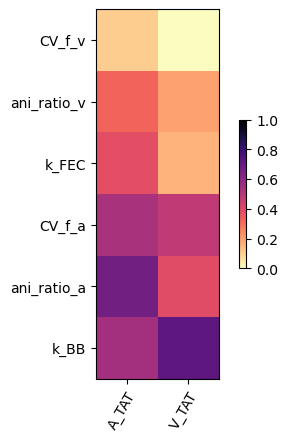

In [22]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

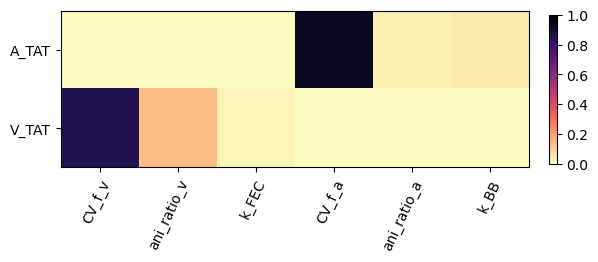

In [15]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [16]:
np.savetxt("Si_total_EP_"+str(mesh)+".csv", Si_total, delimiter=",")
np.savetxt("Si_first_EP_"+str(mesh)+".csv", Si_first, delimiter=",")